<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw12/nn_hw12_fasttext_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *NN HW12*

#### *Fasttext regression model*

Модифицированная версия модели регрессора из [*HW7*](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw7/nn_hw7_fasttext.ipynb):

*   Явно выделяется валидационная часть датасета.
*   Обучающий и валидационный датасеты сохраняются после препроцесснига.
*   Слова без соответствующего **fasttext** эмбеддинга, а также `oov_token` (слова, отсутствующие в словаре токенайзера) заменяются на такое слово из словаря **fasttext**, которого нет в словаре токенайзера (или, другими словами, в обучающем датасете).
*   Оптимизатор заменён на [**Adam**](https://keras.io/optimizers/#adam "Optimizers - Keras Documentation").

---

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
import re
import gc
import warnings

from tqdm import tqdm_notebook

In [0]:
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras import layers as L
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
print(tf.__version__)
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

1.14.0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls -hAlF *.{csv,vec}

-rw------- 1 root root 2.5G Jul  8 10:35 ft_native_300_ru_wiki_lenta_lemmatize.vec
-rw------- 1 root root 107M Jul  8 10:35 test_content.csv
-rw------- 1 root root 1.8G Jul  8 10:36 train_content.csv


## 1. _Данные_

### 1.1 _Подготовка_

In [0]:
train_content = pd.read_csv('train_content.csv')

Очистим текст [от html тегов](https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python "Strip HTML from strings in Python") (простейший вариант, через regexp). Отбросим пустые и совсем короткие тексты. Объединим заголовок и текст статьи. Одновременно сделаем перемешивание (с заданным [random state](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.RandomState.html "numpy.random.RandomState")).

In [0]:
def make_striphtml(regex):
    p = re.compile(regex)
    def striphtml(text):
        return p.sub(' ', text)
    return striphtml

striphtml = make_striphtml('<[^<]+?>')

def select_content_favs(random_state, d, min_len=100, size=1.):
    w = d['content'].notnull()
    d['content'][w] = d['content'][w].apply(striphtml)
    w &= min_len < d['content'].str.len()
    i = np.argwhere(w.values).squeeze()    
    i = i[random_state.choice(len(i), size=int(len(i) * size), replace=False)]
    return ((d['title'][i] + ' ' + d['content'][i]).values, d['favs_lognorm'][i].values)

Явно выделим $20\%$ данных под валидационный датасет (как было отмечено, данные из `test_content.csv` использовать в данном контексте невозможно, поскольку они не размечены).

Также зафиксируем `random state`, чтобы можно было позже воспроизвести валидационный датасет.

In [0]:
train_content = train_content[['title', 'content', 'favs_lognorm']]

X_text, y = select_content_favs(np.random.RandomState(889), train_content, 32)
del train_content

In [0]:
val_split_ix = len(X_text) // 5 * 4

X_train_text, y_train = X_text[:val_split_ix], y[:val_split_ix]
X_val_text, y_val = X_text[val_split_ix:], y[val_split_ix:]
del X_text, y

[ x.shape for x in (X_train_text, y_train, X_val_text, y_val) ]

[(135784,), (135784,), (33947,), (33947,)]

Сохраним обучающий и валидационный датасет, чтобы потом можно было непосредственно их использовать для ELI5 без повторной подготовки (но нам нужны именно тексты, так что токенизацию и паддинг в любом случае придётся повторить).

In [0]:
np.save('nn_hw12_train.npy', np.vstack([X_train_text, y_train]))
np.save('nn_hw12_val.npy', np.vstack([X_val_text, y_val]))

In [0]:
[ s[:100] for s in X_train_text[:3] ]

['Свободный фильм Pioneer One   \r\n \r\nЗдравствуйте, на Хабре  уже упоминался  проект  VODO . Сегодня хо',
 'Python sqlite3: Находим медленные запросы Привет, коллеги! \r\nПри работе с базами данных sqlite перед',
 'Компьютерный алгоритм выбирает самых значимых авторов прошлых лет   \r\n \r\n1 января каждого года — не ']

### 1.2 _Токенизация_

In [0]:
tokenizer = Tokenizer(num_words=2**20, lower=True, oov_token='<%oov_token%>') # '<%oov_token%>' позже заменим на какое-нибудь слово из словаря fasttext
tokenizer.fit_on_texts(X_train_text)

print(f'{len(tokenizer.word_index)} unique tokens')

1837115 unique tokens


In [0]:
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq = tokenizer.texts_to_sequences(X_val_text)

del X_train_text, X_val_text

Распределение текстов по количеству слов:

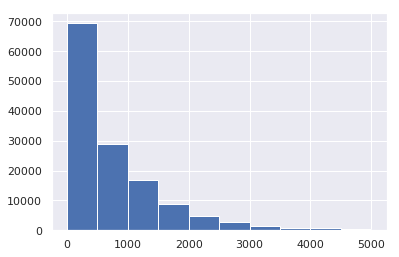

In [0]:
plt.hist([ len(x) for x in X_train_seq ], range=(0, 5000));

In [0]:
max_seq_length = 3000

X_train = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=max_seq_length, padding='post')

del X_train_seq, X_val_seq

## 2. _Fasttext_

DeepPavlov’s [Pre-trained embeddings](http://docs.deeppavlov.ai/en/master/features/pretrained_vectors.html#id4 "Pre-trained embeddings").

In [0]:
!head -7 'ft_native_300_ru_wiki_lenta_lemmatize.vec' | cut -d' ' -f1-10 | sed '2,$ s/.*/&.../'

977837 300
, -0.19691 0.10625 0.22104 -0.022737 0.095721 0.033132 -0.11969 0.17552 0.026835...
. -0.22444 0.1004 0.20901 0.090732 -0.12241 0.036208 -0.017794 0.1247 -0.043839...
в -0.23989 -0.011713 0.15841 0.065439 -0.13313 0.056061 0.028891 0.16164 -0.068493...
и -0.10178 0.044071 0.16131 0.016189 -0.0013021 0.090599 -0.11217 0.10187 -0.057014...
на -0.21902 -0.036972 0.14425 0.09633 -0.15182 -0.077977 -0.028384 0.25189 0.097382...
год -0.22211 0.0023868 0.26481 0.016657 -0.16772 0.13828 0.0073285 0.058437 -0.1876...


In [0]:
def load_vectors(fasttext_vec_path):
    with open(fasttext_vec_path) as fasttext:
        count, length = ( int(x) for x in fasttext.readline().split() ) # header line
        embeddings = {}
        for line in tqdm_notebook(fasttext):
            value = line.split()
            word = value[0]
            coef = np.array(value[1:], dtype=np.float32)
            embeddings[word]=coef
        return count, length, embeddings

In [0]:
embedding_count, embedding_length, embedding_values = load_vectors('ft_native_300_ru_wiki_lenta_lemmatize.vec')

In [0]:
embedding_count, embedding_length, len(embedding_values), len(embedding_values['.'])

(977837, 300, 977837, 300)

## 3. _Модель_

Для упрощения, слова из текста, для которых не найдётся соответствующего вектора эмбеддинга, будем заменять на вектор для произвольно выбранного слова,  которе отсутствует в *обучающем датасете*, но пристутствует в словаре **fasttext**:

In [0]:
for replace_word in embedding_values.keys():
    if not re.match(r'\w{3,}$', replace_word): continue # попробуем найти именно слово, а не, например, символ пунктуации
    if replace_word not in tokenizer.word_index:
        break

replace_word

'епископ'

`oov_token` установим в то же самое слово:

In [0]:
tokenizer.oov_token = replace_word
tokenizer.index_word[tokenizer.word_index['<%oov_token%>']] = replace_word
tokenizer.word_index[replace_word] = tokenizer.word_index['<%oov_token%>']
del tokenizer.word_index['<%oov_token%>']

In [0]:
embedding_matrix = np.zeros((tokenizer.num_words + 1, embedding_length), dtype=np.float32)

for i in tqdm_notebook(range(tokenizer.num_words + 1)):
    try:
        embedding_vector = embedding_values[tokenizer.index_word[i]]
    except KeyError:
        embedding_vector = embedding_values[replace_word] # TODO: using the most primitive logic to address missing words

    embedding_matrix[i] = embedding_vector

del embedding_values, tokenizer

gc.collect()

embedding_matrix.shape

(1048577, 300)

Помимо [MSE](https://keras.io/losses/#mean_squared_error "Losses - Keras Documentation") будем также рассчитывать [коэффициент детерминации](https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/ "Implement a Custom Metric Function in Keras")  $R^2$.

In [0]:
def r2_score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [0]:
def make_model(embedding_matrix, input_length):

    input_layer = L.Input(shape=(input_length,))

    embedding_layer = L.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=False)(input_layer)

    x = L.SpatialDropout1D(0.2)(embedding_layer)
    x = L.Bidirectional(L.CuDNNLSTM(64, return_sequences=True))(x)

    avg_pool1 = L.GlobalAveragePooling1D()(x)
    max_pool1 = L.GlobalMaxPooling1D()(x)

    x = L.concatenate([avg_pool1, max_pool1])

    output_layer = L.Dense(1, activation='linear')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=1e-3, clipnorm=3, clipvalue=3),
                  metrics=[r2_score])

    return model

In [0]:
def plot_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    def plot_ax(ax, hist, title, train, val, loc='best'):
        last_epoch = len(hist[train])
        ax.plot(1 + np.arange(last_epoch), hist[train])
        ax.plot(1 + np.arange(last_epoch), hist[val])
        
        ax.axvline(x=last_epoch, color='r', linestyle=':')
        bottom, top = ax.get_ylim()
        height = top - bottom
        ymid = bottom + height / 2
        ax.annotate(f'{last_epoch}', xy=(last_epoch, ymid))
        
        val_last = hist[val][last_epoch-1]
        ax.axhline(y=val_last, color='g', linestyle=':')
        left, right = ax.get_xlim()
        y2 = [top - height / 3, bottom + height / 3][bool(val_last < ymid)]
        ax.annotate(f'{val_last:.4f}', xy=(last_epoch, val_last), 
                    xytext=(last_epoch - (last_epoch - left) / 4, y2),
                    size = 14,
                    arrowprops=dict(arrowstyle='->',
                                    connectionstyle=f'arc3,rad={.3*[1, -1][bool(val_last < ymid)]:.1f}'))

        ax.set_title(title)
        ax.set_ylabel(train)
        ax.set_xlabel('epoch')
        ax.set_xticks(np.arange(0, last_epoch, 5))
        ax.legend(['train', 'val'], loc=loc)

    plot_ax(ax[0], hist, 'MSE', 'loss', 'val_loss')
    plot_ax(ax[1], hist, 'R2', 'r2_score', 'val_r2_score')

In [0]:
model = make_model(embedding_matrix, max_seq_length)

history = model.fit(X_train, y_train, batch_size=256, epochs=25, validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 135784 samples, validate on 33947 samples
Epoch 1/25
135784/135784 [==============================] - 755s 6ms/step - loss: 1.6129 - r2_score: 0.4379 - val_loss: 1.3906 - val_r2_score: 0.5150
Epoch 2/25
135784/135784 [==============================] - 751s 6ms/step - loss: 1.3676 - r2_score: 0.5231 - val_loss: 1.3004 - val_r2_score: 0.5465
Epoch 3/25
135784/135784 [==============================] - 751s 6ms/step - loss: 1.2767 - r2_score: 0.5548 - val_loss: 1.2412 - val_r2_score: 0.5669
Epoch 4/25
135784/135784 [==============================] - 751s 6ms/step - loss: 1.2216 - r2_score: 0.5743 - val_loss: 1.2023 - val_r2_score: 0.5807
Epoch 5/25
135784/135784 [==============================] - 750s 6ms/step - loss: 1.1859 - r2_score: 0.5862 - val_loss: 1.2288 - val_r2_score: 0.5714
Epoch 6/25
135784/135784 [==============================] - 751s 6ms/step - loss: 1.1525 - r2_score: 0.5981 - val_loss: 1.1961 - val_r2_score: 0.5828
Epoch 7/25
135784/135784 [=======================

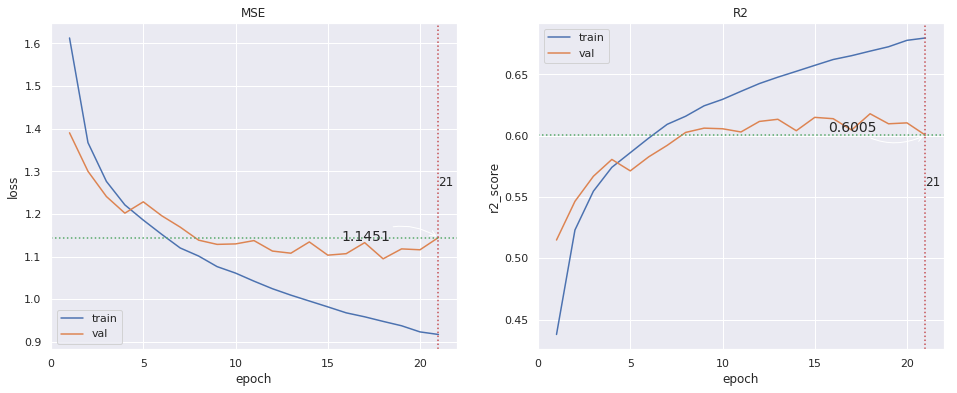

In [0]:
plot_history(history.history)

In [0]:
model.save('nn_hw12_regressor.h5')

### Score:

In [0]:
print(f'[train] MSE: {history.history["loss"][-1]:.4f}, R2: {history.history["r2_score"][-1]:.4f}')
print(f'[validation] MSE: {history.history["val_loss"][-1]:.4f}, R2: {history.history["val_r2_score"][-1]:.4f}')

[train] MSE: 0.9178, R2: 0.6797
[validation] MSE: 1.1451, R2: 0.6005
